In [6]:
import os
import pandas as pd
import zarr
import xarray as xr
import sparse
import numpy as np

In [7]:
species_df = pd.read_csv("data/species_oi.csv", sep="\t")
species_df["time"]= pd.to_datetime(species_df[["year", "month"]].assign(day=1))

# Specify the columns you’re indexing on
idx_cols = ["time", "specieskey", "genuskey", "familykey", "classkey", "eeacellcode"]

# Drop any row that has a NaN in one of those columns
species_df_clean = species_df.dropna(subset=idx_cols)

# Now set the MultiIndex
species_df_indexed = species_df_clean.set_index(idx_cols)

#2. Build coords & data, ensuring no −1’s sneak in

# Stack the level codes into an (ndim, nnz) array
coords = np.vstack(species_df_indexed.index.codes)

# Pull out the data
data = species_df_indexed["occurrences"].values

# Mask out any lingering invalid positions just to be safe
valid_mask = (coords >= 0).all(axis=0)
coords = coords[:, valid_mask]
data   = data[valid_mask]

# Compute the shape
shape = [len(level) for level in species_df_indexed.index.levels]

# 3. Sparse COO
sparse_data = sparse.COO(coords, data, shape=shape)

# 4. xarray DataArray
da = xr.DataArray(
    sparse_data,
    dims=species_df_indexed.index.names,
    coords={name: level for name, level in 
            zip(species_df_indexed.index.names,
                species_df_indexed.index.levels)}
)


In [11]:
len(set(species_df["time"].values))

488

In [43]:
sparse_data.coords

array([[  0,   0,   0, ..., 487, 487, 487],
       [  2,   3, 123, ..., 138, 138, 138],
       [  1,   2,  98, ...,   6,   6,   6],
       [ 12,  54,  57, ...,  18,  18,  18],
       [  2,   2,   3, ...,   2,   2,   2],
       [489, 517, 857, ..., 761, 807, 963]], shape=(6, 99549), dtype=int16)

In [42]:
sparse_data.data

array([1, 1, 1, ..., 1, 1, 1], shape=(99549,))

In [8]:
da

Format,coo
Data Type,int64
Shape,"(488, 140, 110, 60, 8, 1047)"
nnz,99549
Density,2.635775639879872e-08
Read-only,True
Size,1.9M
Storage ratio,0.00


In [51]:
avg_per_slice = {name: (sp.nnz/shape[i]) for i,name in enumerate(dims)}
avg_per_slice

{'time': 203.99385245901638,
 'specieskey': 711.0642857142857,
 'genuskey': 904.9909090909091,
 'familykey': 1659.15,
 'classkey': 12443.625,
 'eeacellcode': 95.08022922636103}

In [53]:
hist = {name: np.bincount(coords[i], minlength=shape[i]) 
        for i,name in enumerate(dims)}
medians = {n: np.median(h) for n,h in hist.items()}
medians

{'time': np.float64(86.0),
 'specieskey': np.float64(275.0),
 'genuskey': np.float64(478.5),
 'familykey': np.float64(785.0),
 'classkey': np.float64(1428.5),
 'eeacellcode': np.float64(51.0)}

In [54]:
hist

{'time': array([   4,   67,  107,   64,   10,    2,  127,   92,   43,    7,   23,
          10,   11,   11,   24,   50,   36,   27,    4,   12,   77,    9,
          12,   17,    4,   12,   19,   54,   13,   81,   21,   15,  126,
          18,   17,   15,   11,   30,   39,   43,  121,   62,   81,   60,
          32,    9,   22,   11,   20,   11,   11,   11,   16,   14,   14,
          60,   44,   19,   21,   21,    6,    6,   10,   17,    6,    1,
           9,   27,   33,   43,   10,    9,   17,    3,    4,   58,   88,
          21,  123,   58,   41,   15,    4,    3,    2,    1,    7,    7,
         113,   43,    2,   24,    1,    4,    3,    2,    3,    3,   71,
          42,   51,   15,   40,    6,   23,    3,    1,    3,    8,   34,
          22,   94,   41,   74,   48,   12,   32,   12,    3,    1,    3,
          75,   83,    1,   33,   51,    1,    2,   12,    5,    3,  107,
         104,  100,  190,  262,  140,   70,    2,    5,   10,    9,   59,
         237,  330,  237,  219

In [55]:
import numpy as np

sp     = da.data
coords = sp.coords     # (ndim, nnz)
shape  = sp.shape      # list of lengths per dim
dims   = da.dims       # list of dim names

# Build histogram of nonzero counts per label index
hist = {
    dim: np.bincount(coords[i], minlength=shape[i])
    for i, dim in enumerate(dims)
}


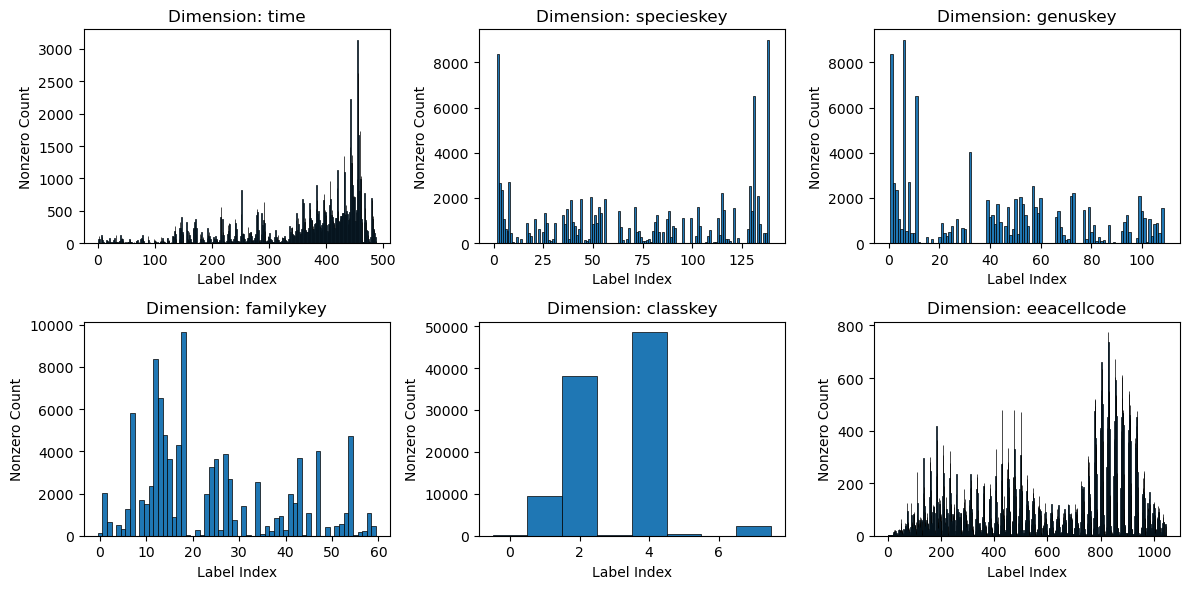

In [59]:
import math
import matplotlib.pyplot as plt

n_dims = len(dims)
ncols  = 3
nrows  = math.ceil(n_dims / ncols)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols * 4, nrows * 3),
    tight_layout=True
)
axes = axes.flatten()

for ax, (dim, counts) in zip(axes, hist.items()):
    ax.bar(
        np.arange(len(counts)),
        counts,
        width=1.0,
        edgecolor="black",
        linewidth=0.5
    )
    ax.set_title(f"Dimension: {dim}")
    ax.set_xlabel("Label Index")
    ax.set_ylabel("Nonzero Count")

# Turn off any leftover subplots
for ax in axes[n_dims:]:
    ax.set_visible(False)

plt.savefig("Dim_distribution.png")

In [9]:
print("Zarr version:", zarr.__version__)
print("xarray version:", xr.__version__)

Zarr version: 2.18.7
xarray version: 2024.11.0


In [10]:
# Assuming `da` is an xarray.DataArray backed by sparse.COO
da.to_dataset(name="occurrences").to_zarr("test_sparse.zarr", mode="w",zarr_format=2)

TypeError: SparseArray.astype() got an unexpected keyword argument 'order'

In [3]:
import numpy as np
lat = np.array([50.873744, 50.865411, 50.857078, 50.848744, 50.840411, 50.832078,
       50.823744, 50.815411, 50.807078, 50.798744, 50.790411, 50.782078,
       50.773744, 50.765411, 50.757078, 50.748744, 50.740411, 50.732078,
       50.723744, 50.715411, 50.707078, 50.698744, 50.690411])
long = np.array([4.175538, 4.183871, 4.192204, 4.200538, 4.208871, 4.217204, 4.225538,
       4.233871, 4.242204, 4.250538, 4.258871, 4.267204, 4.275538, 4.283871,
       4.292204, 4.300538, 4.308871, 4.317204, 4.325538, 4.333871, 4.342204,
       4.350538, 4.358871, 4.367204, 4.375538, 4.383871, 4.392204, 4.400538,
       4.408871, 4.417204, 4.425538, 4.433871, 4.442204, 4.450538, 4.458871,
       4.467204, 4.475538, 4.483871, 4.492204, 4.500538, 4.508871, 4.517204,
       4.525538, 4.533871, 4.542204, 4.550538, 4.558871, 4.567204, 4.575538,
       4.583871, 4.592204, 4.600538, 4.608871, 4.617204, 4.625538, 4.633871,
       4.642204, 4.650538, 4.658871, 4.667204, 4.675538, 4.683871, 4.692204,
       4.700538, 4.708871, 4.717204, 4.725538, 4.733871, 4.742204])

In [23]:
subset.iloc[0]["decimallatitude"], subset.iloc[0]["decimallongitude"]

(np.float64(50.738), np.float64(4.472))

In [25]:
import random
from geopy.distance import distance
from geopy.point import Point

def randomize_observation(lat, long, coordinate_uncertainty_in_meters):
    """
    Perturb coordinates by a random distance and direction using geodesic calculations.
    """
    # Random distance in meters (uniform between 0 and uncertainty)
    dist = random.uniform(0, coordinate_uncertainty_in_meters)

    # Random bearing in degrees (0 to 360)
    bearing = random.uniform(0, 360)

    # Create point and move it
    origin = Point(lat, long)
    destination = distance(meters=dist).destination(origin, bearing)

    return destination.latitude, destination.longitude

def preprocess_dataset(df):
    #Fill in the missing values in uncertainty coordinates
    df["coordinateuncertaintyinmeters"]=df["coordinateuncertaintyinmeters"].fillna(0)
    # Initialize randomized_lat and randomized_long safely using .loc
    df.loc[df["coordinateuncertaintyinmeters"] == 0, "randomized_lat"] = df.loc[df["coordinateuncertaintyinmeters"] == 0, "decimallatitude"]
    df.loc[df["coordinateuncertaintyinmeters"] == 0, "randomized_long"] = df.loc[df["coordinateuncertaintyinmeters"] == 0, "decimallongitude"]
    for idx, row in df[df["coordinateuncertaintyinmeters"]!=0].iterrows():
        r_lat, r_long = randomize_observation(row["decimallatitude"], row["decimallongitude"], row["coordinateuncertaintyinmeters"])
        df.loc[idx, "randomized_lat"] = r_lat
        df.loc[idx, "randomized_long"] = r_long
    return df

In [26]:
species_df_trans = preprocess_dataset(species_df)
species_df_trans

,year,month,decimallatitude,decimallongitude,specieskey,species,coordinateuncertaintyinmeters,randomized_lat,randomized_long
0,2020,4,50.700000,4.364167,5376075,Alliaria petiolata,0.0,50.700000,4.364167
1,2016,6,50.829933,4.714428,3169340,Lysimachia punctata,0.0,50.829933,4.714428
2,2017,5,50.848868,4.172736,2926557,Glechoma hederacea,21.0,50.848976,4.172823
3,2020,4,50.800234,4.230564,5384795,Silene dioica,21.0,50.800178,4.230553
4,2020,4,50.851389,4.430000,5376075,Alliaria petiolata,0.0,50.851389,4.430000
...,...,...,...,...,...,...,...,...,...
142711,2005,6,50.862000,4.471000,7972010,Cardamine pratensis,1000.0,50.856795,4.462781
142712,2005,6,50.862000,4.471000,2706163,Holcus mollis,1000.0,50.863130,4.466104
142713,2005,6,50.862000,4.471000,2890668,Geranium robertianum,1000.0,50.857656,4.469970
142714,2005,6,50.862000,4.471000,2926557,Glechoma hederacea,1000.0,50.862123,4.470105


In [ ]:
50.862000	4.471000

In [11]:
(species_df.iloc[142711]["decimallatitude"],species_df.iloc[142711]["decimallongitude"]),randomize_observation(species_df.iloc[142711]["decimallatitude"],species_df.iloc[142711]["decimallongitude"],1000)

((np.float64(50.862), np.float64(4.471)),
 (50.86218876513761, 4.470914387009105))

In [35]:
def find_nearest_index(array, value):
    """Find index of the nearest value in a sorted 1D array."""
    idx = np.abs(array - value).argmin()
    return idx

# Vectorize the function
vfind_nearest_index = np.vectorize(find_nearest_index)

#vfind_nearest_index(lat, subset["decimallatitude"].values)
# Find indices of the closest lat/lon grid cell for each observation
#lat_indices = vfind_nearest_index(grid_lats, obs_lats)
#lon_indices = vfind_nearest_index(grid_lons, obs_lons)

In [36]:
lat[find_nearest_index(lat, subset.iloc[0]["decimallatitude"])]

np.float64(50.757078)

In [ ]:
1) Bereken de index van alle punten door over de kolommen te itereren en de dichtst bijzijnde index op te zoeken
2) Groepeer per jaar, maand en species
3) Schrijf een constructor functie die deze subsectie kan omzetten in een 2D array 
4) Vul de ontbrekende arrays aan om een complete tijdsreeks te voorzien

In [28]:
subset = species_df[(species_df["year"]==1980)]
subset

,year,month,decimallatitude,decimallongitude,specieskey,species,coordinateuncertaintyinmeters
4914,1980,2,50.75652,4.46109,2882316,Fagus sylvatica,700.0
4916,1980,2,50.77452,4.41860,2882316,Fagus sylvatica,700.0
4985,1980,7,50.76534,4.58869,3012167,Sorbus aucuparia,700.0
5010,1980,4,50.81049,4.37608,5334277,Lonicera periclymenum,700.0
5011,1980,7,50.80997,4.71659,5334277,Lonicera periclymenum,700.0
...,...,...,...,...,...,...,...
140910,1980,9,50.78600,4.63400,2475532,Alcedo atthis,5000.0
140911,1980,9,50.83300,4.66700,2475532,Alcedo atthis,5000.0
140912,1980,9,50.78600,4.63400,2475532,Alcedo atthis,5000.0
140918,1980,11,50.73600,4.46500,2477872,Dryocopus martius,5000.0


In [42]:
species_df["lat_idx"]=[find_nearest_index(lat, lat_val) for lat_val in species_df["decimallatitude"]]
species_df["long_idx"]=[find_nearest_index(long, long_val) for long_val in species_df["decimallongitude"]]
species_df

,year,month,decimallatitude,decimallongitude,specieskey,species,coordinateuncertaintyinmeters,lat_idx,long_idx
0,2020,4,50.700000,4.364167,5376075,Alliaria petiolata,NaN,21,23
1,2016,6,50.829933,4.714428,3169340,Lysimachia punctata,NaN,5,65
2,2017,5,50.848868,4.172736,2926557,Glechoma hederacea,21.0,3,0
3,2020,4,50.800234,4.230564,5384795,Silene dioica,21.0,9,7
4,2020,4,50.851389,4.430000,5376075,Alliaria petiolata,NaN,3,31
...,...,...,...,...,...,...,...,...,...
142711,2005,6,50.862000,4.471000,7972010,Cardamine pratensis,1000.0,1,35
142712,2005,6,50.862000,4.471000,2706163,Holcus mollis,1000.0,1,35
142713,2005,6,50.862000,4.471000,2890668,Geranium robertianum,1000.0,1,35
142714,2005,6,50.862000,4.471000,2926557,Glechoma hederacea,1000.0,1,35


In [ ]:
species_df["lat_idx"] = 

In [30]:
subset[subset["specieskey"]==2882316]

,year,month,decimallatitude,decimallongitude,specieskey,species,coordinateuncertaintyinmeters
4914,1980,2,50.75652,4.46109,2882316,Fagus sylvatica,700.0
4916,1980,2,50.77452,4.41860,2882316,Fagus sylvatica,700.0
5884,1980,2,50.77452,4.41860,2882316,Fagus sylvatica,700.0
15500,1980,2,50.80139,4.53211,2882316,Fagus sylvatica,700.0
17240,1980,7,50.77440,4.54619,2882316,Fagus sylvatica,700.0
17241,1980,7,50.80110,4.67397,2882316,Fagus sylvatica,700.0
21803,1980,7,50.76534,4.58869,2882316,Fagus sylvatica,700.0
23413,1980,7,50.79208,4.68809,2882316,Fagus sylvatica,700.0
23723,1980,9,50.77452,4.41860,2882316,Fagus sylvatica,700.0
29613,1980,4,50.76554,4.40441,2882316,Fagus sylvatica,700.0


In [2]:
ls

 Volume in drive C is OS
 Volume Serial Number is 1C25-B250

 Directory of C:\Users\niels\Documents\Repositories\BmC\scripts\prototype

05/08/2025  13:15    <DIR>          .
02/07/2025  11:43    <DIR>          ..
28/07/2025  20:39    <DIR>          .ipynb_checkpoints
28/07/2025  14:39            41.203 chelsa.ipynb
29/07/2025  11:54           438.682 Cubing.ipynb
05/08/2025  13:12    <DIR>          data
05/08/2025  13:15           123.183 data_generation.ipynb
28/07/2025  14:39    <DIR>          debug
29/07/2025  10:07            51.225 GBIF.ipynb
02/07/2025  10:13               758 gbifCube.sh
03/07/2025  10:23    <DIR>          img
03/07/2025  15:29    <DIR>          inp
28/07/2025  20:17    <DIR>          out
               5 File(s)        655.051 bytes
               8 Dir(s)  210.298.499.072 bytes free


In [ ]:

inp_path="data/"
input_file="species_oi.csv"

In [45]:
def gbif_sparse_array(dataframe, idx_cols, var_col, add_time=True):
    """
    A function that takes a pandas data frame and extracts the data so that it can be converted into a data array object.
    The sparse representation prevents memory bloating when converting to an actual cube

    Arguments
        dataframe (pd.dataframe): A dataframe that is the result from a GBIF SQL query
        idx_cols (list<str>): A list of the columns through which the table should be indexed. These columns will serve as the dimensions
                                of the data array
        var_col (str): The column which will be used as the data variable in the data array
        add_time (opt, bool): Option to enable adding a year-month datetime column to the dataframe.
    Returns
        data array: A data array with the data in sparse coordinates representation
    """
    
    if add_time:
       dataframe["time"]= pd.to_datetime(dataframe[["year", "month"]].assign(day=1)) 
       idx_cols.append("time")  
    #Remove any rows that do not have entries in the indexation columns
    dataframe = dataframe.dropna(subset=idx_cols)

    #Index the column based on the provided indexation variables
    dataframe_idx = dataframe.set_index(idx_cols)

    #Extract the coordinates for each of the indexation variables
    coords = np.vstack(dataframe_idx.index.codes)

    # Pull out the data
    data = dataframe_idx[var_col].values

    #Select all coordinates that have an code different from -1. Negative code means a missing or placeholder level
    #(coords >= 0) is a (ndim, nnz) boolean array marking which level‐codes are nonnegative
    #.all(axis=0) collapses that to a 1-D mask of length nnz
    valid_mask = (coords >= 0).all(axis=0)
    #keep only fully valid coordinate columns
    coords = coords[:, valid_mask]
    #keep only the matching data values
    data   = data[valid_mask]

    # Compute the shape
    shape = [len(level) for level in dataframe_idx.index.levels]

    sparse_data = sparse.COO(coords, data, shape=shape)

    da = xr.DataArray(
        sparse_data,
        dims=dataframe_idx.index.names,
        coords={name: level for name, level in 
                zip(dataframe_idx.index.names,
                    dataframe_idx.index.levels)}
    )
    return da

In [46]:
species_df = pd.read_csv("data/species_oi.csv", sep="\t")

In [40]:
species_df

,year,month,eeacellcode,specieskey,species,genuskey,genus,familykey,family,orderkey,order,classkey,class,occurrences,distinctobservers
0,1980,1,1kmE3930N3081,2475532,Alcedo atthis,2475493,Alcedo,2984,Alcedinidae,1447,Coraciiformes,212.0,Aves,1,1
1,1980,1,1kmE3931N3085,2477872,Dryocopus martius,2477865,Dryocopus,9333,Picidae,724,Piciformes,212.0,Aves,1,1
2,1980,1,1kmE3945N3093,5743122,Lucanus cervus,3263258,Lucanus,3263244,Lucanidae,1470,Coleoptera,216.0,Insecta,1,1
3,1980,1,1kmE3927N3090,9444556,Lanius excubitor,2483315,Lanius,9315,Laniidae,729,Passeriformes,212.0,Aves,1,1
4,1980,2,1kmE3928N3080,2475532,Alcedo atthis,2475493,Alcedo,2984,Alcedinidae,1447,Coraciiformes,212.0,Aves,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99663,2020,12,1kmE3937N3087,9752617,Ardea alba,2480922,Ardea,3685,Ardeidae,7190953,Pelecaniformes,212.0,Aves,1,1
99664,2020,12,1kmE3949N3096,9752617,Ardea alba,2480922,Ardea,3685,Ardeidae,7190953,Pelecaniformes,212.0,Aves,1,1
99665,2020,12,1kmE3943N3094,9752617,Ardea alba,2480922,Ardea,3685,Ardeidae,7190953,Pelecaniformes,212.0,Aves,1,1
99666,2020,12,1kmE3936N3088,9752617,Ardea alba,2480922,Ardea,3685,Ardeidae,7190953,Pelecaniformes,212.0,Aves,1,1


In [51]:
idx_cols = ["specieskey", "genuskey", "familykey", "classkey", "eeacellcode"]
var_col = "occurrences"
test=gbif_sparse_array(species_df, idx_cols, var_col)

In [52]:
test.sel(specieskey=2432427)

Format,coo
Data Type,int64
Shape,"(110, 60, 8, 1047, 488)"
nnz,11
Density,4.0774839379752713e-10
Read-only,True
Size,198
Storage ratio,0.00
